In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # to build a classification tree 
from sklearn.tree import plot_tree #to draw a classification tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score #for cross validation
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix

In [3]:
df=pd.read_csv('../input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

All are float or integer datatype chance of missing value entered with random number is checked.

In [6]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

All the columns are filled so we can confirm that our dataset does not have missing values.

In [7]:
corr=df.corr()
corr.style.background_gradient(cmap='coolwarm')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


<AxesSubplot:xlabel='quality', ylabel='free sulfur dioxide'>

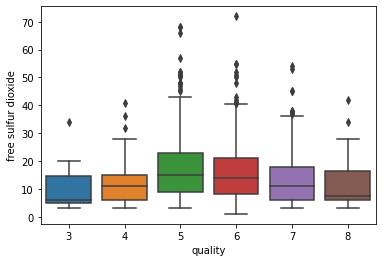

In [8]:
sns.boxplot(x='quality',y='free sulfur dioxide',data=df)

<AxesSubplot:xlabel='quality', ylabel='total sulfur dioxide'>

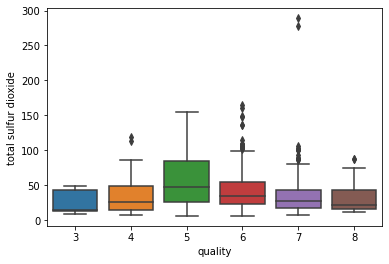

In [9]:
sns.boxplot(x='quality',y='total sulfur dioxide',data=df)

In [10]:
# dropping fixed acidity, free sulfur dioxide
df=df.drop(['fixed acidity','free sulfur dioxide'],axis=1)

<AxesSubplot:xlabel='quality', ylabel='volatile acidity'>

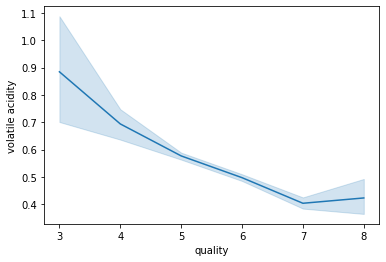

In [11]:
sns.lineplot(x='quality',y='volatile acidity',data=df)

we can infer a trend in volatile acidity which tend to decrese quality as it increases

In [12]:
X=df.iloc[:,1:9]
Y=df.iloc[:,9]

In [13]:
Y.unique()

array([5, 6, 7, 4, 8, 3])

To get the binary output we need convert good for Y>6.5 and else bad quality.

In [14]:
Y.values[Y.values < 6.5] = 0

In [15]:
Y.values[Y.values > 6.5] = 1

You can use apply with list comprehension:
Y = Y.apply(lambda x: [0 if y <= 6.5 else 1 for y in x])

In [16]:
Y.unique()

array([0, 1])

In [17]:
Y.value_counts()

0    1382
1     217
Name: quality, dtype: int64

Splittting data in training and testing

<AxesSubplot:xlabel='quality', ylabel='Count'>

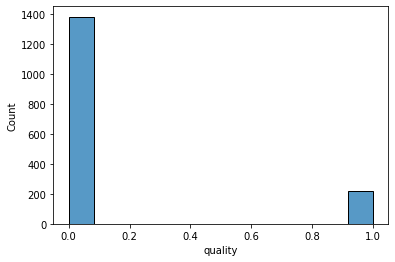

In [18]:
sns.histplot(data=Y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Creating a decision tree and fitting it into a training set

In [20]:
DC=DecisionTreeClassifier(random_state=42)
model=DC.fit(X_train,y_train)

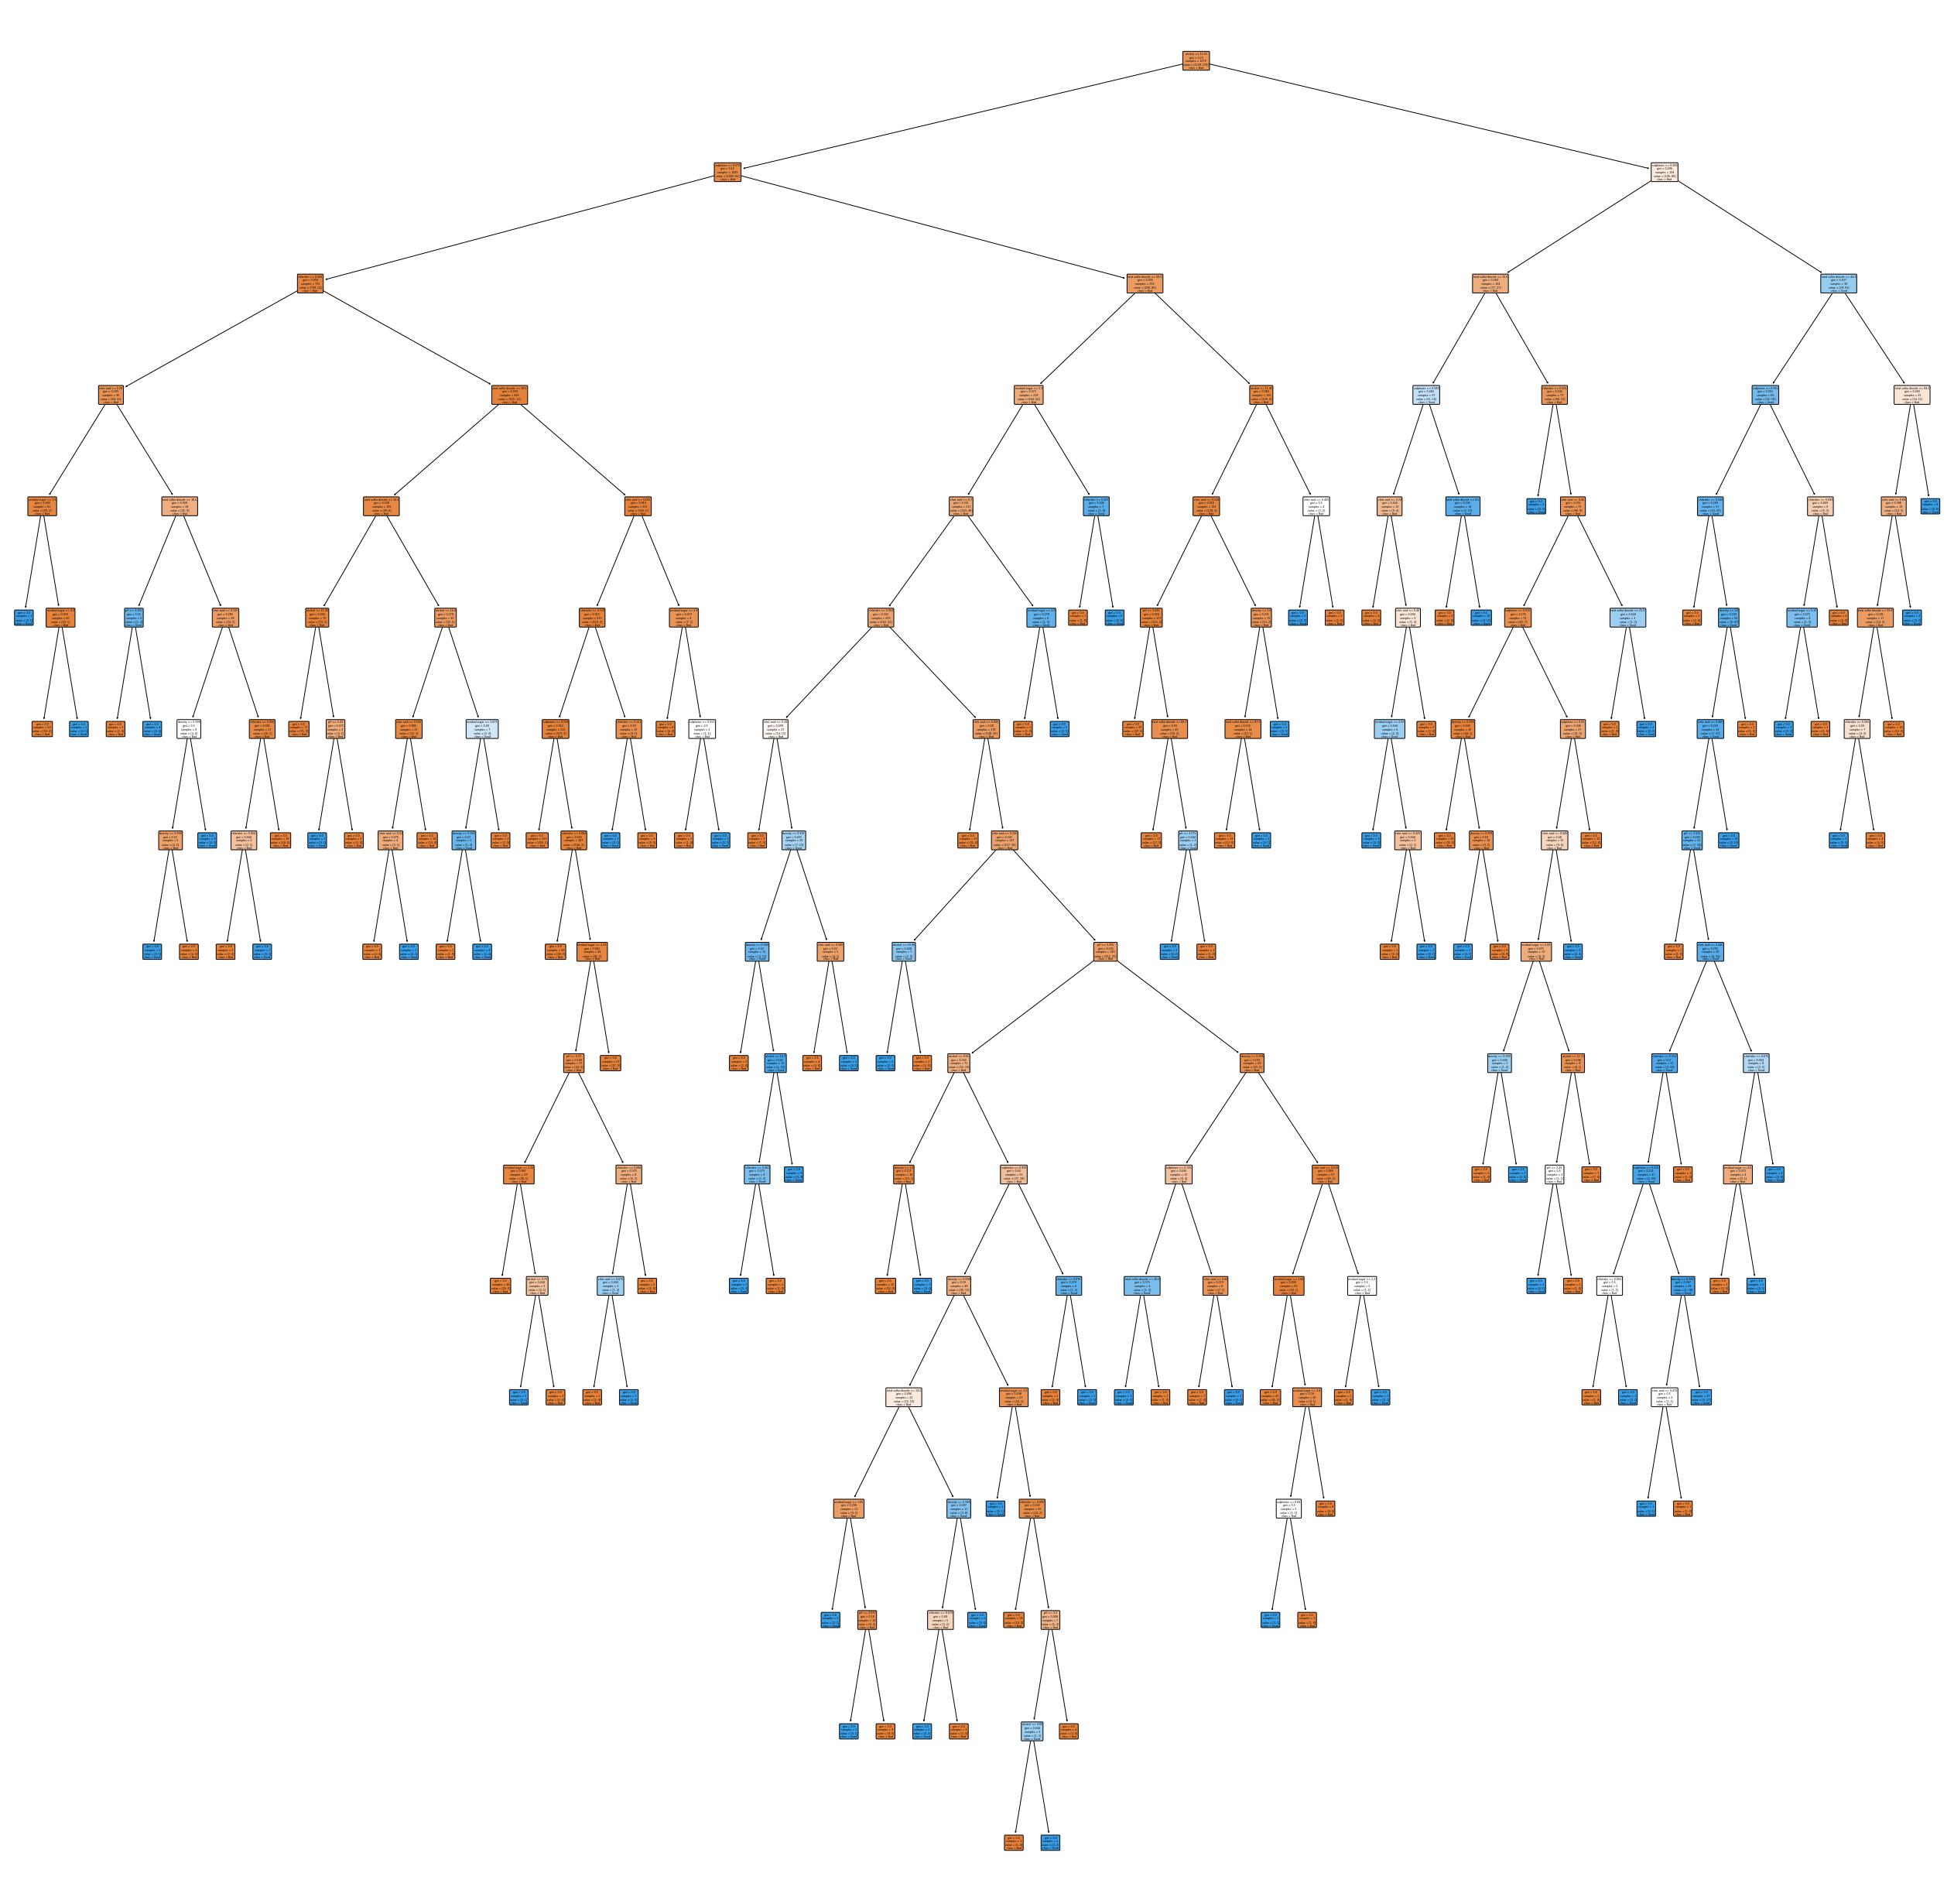

In [21]:
plt.figure(figsize=(45,45))
plot_tree(model,filled=True,rounded=True,feature_names=X_train.columns,class_names=["Bad","Good"])
plt.show()

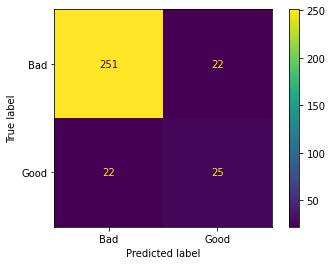

In [22]:
plot_confusion_matrix(model,X_test,y_test,display_labels=["Bad","Good"])

In the confusion matrix, we can see that 251+22 = 273 wine are bad in taste of which 128 are correctly classified. And of the 22+25 = 22 wine are good of which 10 are correctly classified. 
It seem that classification tree is overfit, and require pruning

Cost Complexity Pruning is the action of selectively removing certain parts of a trees to promote its growth. Reducing the number of leaf nodes may result in slightly worse training accuracy, but greatly improve testing performance. Alpha is a pruning parameter, and the higher the alpha, the more nodes will be pruned.

In [23]:
path = model.cost_complexity_pruning_path(X_train, y_train) # Determine values for alpha
ccp_alphas = path.ccp_alphas                                 # extract different values for alpha
ccp_alphas = ccp_alphas[:-1]                                 # Exclude the maximum values

In [24]:
clf_dts = []   ## Create an array to put decision trees in

In [25]:
## Create one decision tree per alpha and store in array
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

In [26]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

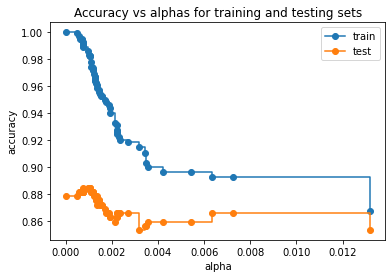

In [27]:

fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs alphas for training and testing sets')
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
ax.legend()
plt.show()

from graph, a good value for alpha might be 0.01 as the tesing accuracy is the highest at this value.

In [28]:
DT = DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)
A=cross_val_score(DT,X_train,y_train,scoring='accuracy',cv=5).mean()
A

0.8889889705882353

Finding best alpha

<AxesSubplot:xlabel='alpha'>

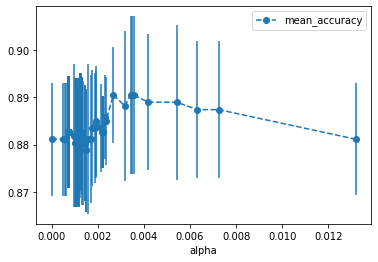

In [29]:
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                            columns=['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

In [30]:
best_alpha = alpha_results.iloc[alpha_results['mean_accuracy'].idxmax(),]['alpha']

In [31]:
best_alpha

0.0034257087423623794

Evaluating Final Model

In [32]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_dt_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0034257087423623794, random_state=42)

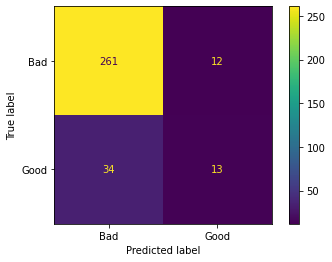

In [33]:
plot_confusion_matrix(clf_dt_pruned,X_test,y_test,display_labels=["Bad","Good"])

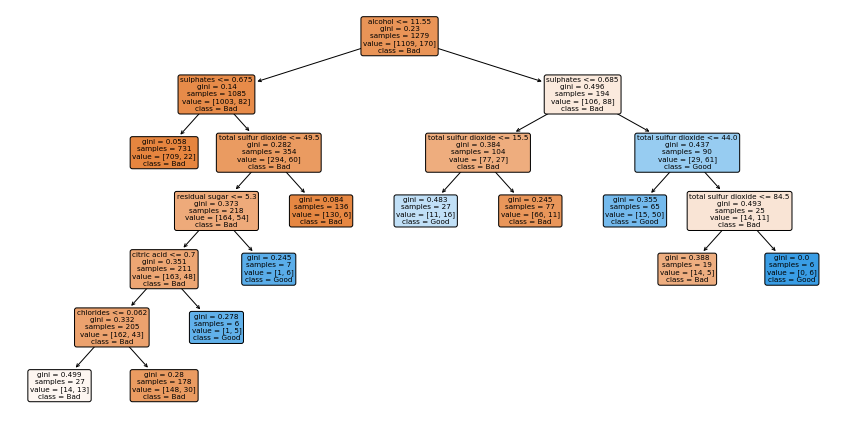

In [34]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned, 
         filled=True,
         rounded=True,
         class_names=["Bad","Good"],
         feature_names=X_train.columns);

This is the final tree

In [35]:
# y_pred=model.predict(X_test)

In [36]:
# importance=DC.feature_importances_
# plt.bar([x for x in range(len(importance))], importance)